### Raster Classification Steps:

You can break your raster processing workflow into several steps as follows:

 *   Data import / cleanup: load and “clean” the data. This includes cropping, removing with nodata values
 
 *   Data Exploration: understand the range and distribution of values in your data. This may involve plotting histograms and scatter plots to determine what classes are appropriate for our data
 
 *   Reclassify the Data: Once you understand the distribution of your data, you are ready to reclassify. There are statistical and non-statistical approaches to reclassification. Here you will learn how to manuall reclassify a raster using bins that you define in your data exploration step.

In [2]:
import rasterio as rio
from rasterio.plot import plotting_extent
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import earthpy as et
plt.ion()
# Set plot parameters
plt.rcParams['figure.figsize'] = (8, 8)
# Prettier plotting with seaborn
import seaborn as sns; 
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

os.chdir(os.path.join(et.io.HOME, 'colorado-flood'))


In [4]:
dtm_path = './spatial/boulder-leehill-rd/pre-flood/lidar/pre_DTM.tif'
dsm_path = './spatial/boulder-leehill-rd/pre-flood/lidar/pre_DSM.tif'
with rio.open(dtm_path) as src:
    lidar_dtm_im = src.read(1, masked=True)
    spatial_extent = plotting_extent(src)
    
with rio.open(dsm_path) as src:
    lidar_dsm_im = src.read(1, masked=True)
    spatial_extent = plotting_extent(src)

lidar_chm_im = lidar_dsm_im - lidar_dtm_im
lidar_chm_im


masked_array(
  data=[[--, --, --, ..., 0.0, 0.1700439453125, 0.9600830078125],
        [--, --, --, ..., 0.0, 0.090087890625, 1.6400146484375],
        [--, --, --, ..., 0.0, 0.0, 0.0799560546875],
        ...,
        [--, --, --, ..., 0.0, 0.0, 0.0],
        [--, --, --, ..., 0.0, 0.0, 0.0],
        [--, --, --, ..., 0.0, 0.0, 0.0]],
  mask=[[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=-3.402823e+38,
  dtype=float32)

In [5]:
print('CHM min value:' ,lidar_chm_im.min())
print('CHM max value:' ,lidar_chm_im.max())

CHM min value: 0.0
CHM max value: 26.930054


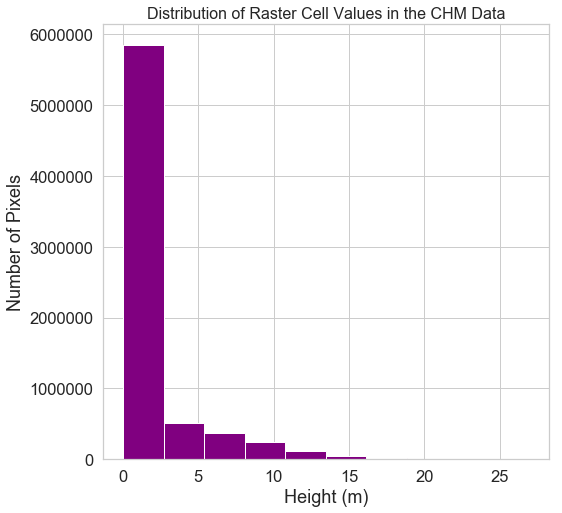

In [6]:
fig, ax = plt.subplots(figsize=(8,8))

ax.hist(lidar_chm_im.ravel(), 
        color='purple', 
        edgecolor='white')
ax.set_title("Distribution of Raster Cell Values in the CHM Data",
             fontsize = 16)
ax.set(xlabel="Height (m)", 
       ylabel="Number of Pixels");


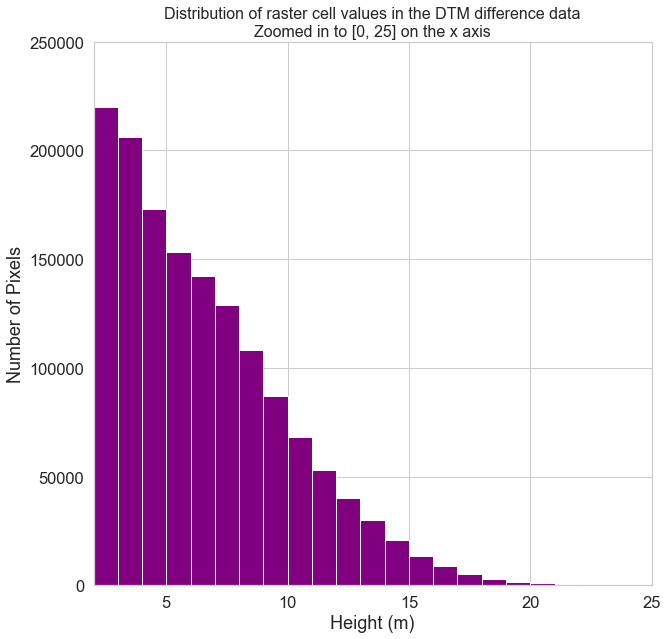

In [7]:
# Histogram
fig, ax = plt.subplots(figsize = (10,10))
xlim = [0, 25]
ax.hist(lidar_chm_im.ravel(), 
        color='purple', edgecolor='white', range=xlim,
        bins=range(*xlim))
ax.set(ylabel="Number of Pixels", xlabel="Height (m)",
       xlim=[2, 25], ylim=[0, 250000]);
ax.set_title("Distribution of raster cell values in the DTM difference data\nZoomed in to {} on the x axis".format(xlim),
             fontsize=16);


In [8]:
# Patches = the matplotlib objects drawn
counts, bins, patches = ax.hist(lidar_chm_im.ravel(), 
                                color='springgreen', 
                                bins=50, range=xlim)
# Print histogram outputs
print("counts:", counts)
print("bins:", bins)


counts: [5.292785e+06 1.553170e+05 1.280370e+05 1.165510e+05 1.097430e+05
 1.103950e+05 1.075280e+05 9.857900e+04 8.923400e+04 8.394700e+04
 7.912300e+04 7.393400e+04 7.166900e+04 7.052100e+04 6.704300e+04
 6.163900e+04 5.638900e+04 5.193200e+04 4.619300e+04 4.067400e+04
 3.644200e+04 3.187700e+04 2.842800e+04 2.455300e+04 2.162000e+04
 1.861300e+04 1.609500e+04 1.377600e+04 1.142400e+04 9.402000e+03
 7.504000e+03 6.195000e+03 4.883000e+03 3.901000e+03 2.954000e+03
 2.306000e+03 1.776000e+03 1.342000e+03 1.027000e+03 7.060000e+02
 5.250000e+02 3.580000e+02 2.710000e+02 1.600000e+02 1.130000e+02
 9.900000e+01 4.700000e+01 4.400000e+01 2.100000e+01 1.600000e+01]
bins: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25. ]


(0, 30)

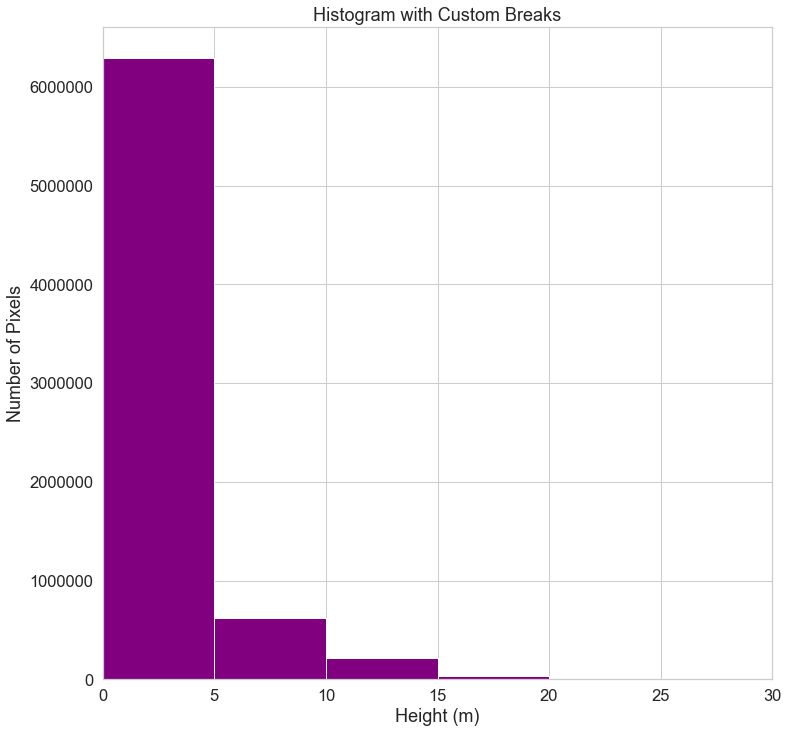

In [12]:
fig, ax = plt.subplots(figsize=(12,12))
ax.hist(lidar_chm_im.ravel(), color='purple', 
        edgecolor='white', 
        bins=[0, 5, 10, 15, 20, 30])
ax.set(title="Histogram with Custom Breaks",
       xlabel="Height (m)", ylabel="Number of Pixels");
plt.xlim(0,30)

(0, 30)

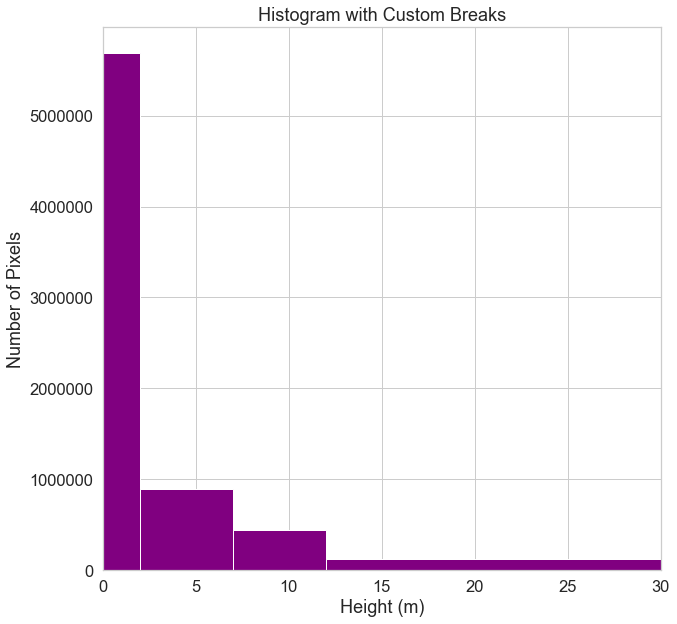

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
ax.hist(lidar_chm_im.ravel(), 
        color='purple', 
        edgecolor='white', 
        bins=[0, 2, 7, 12, 30])
ax.set(title="Histogram with Custom Breaks",
       xlabel="Height (m)", 
       ylabel="Number of Pixels");
plt.xlim(0,30)

In [17]:
# Define bins that you want, and then classify the data
class_bins = [lidar_chm_im.min(), 2, 7, 12, np.inf]

# You'll classify the original image array, then unravel it again for plotting
lidar_chm_im_class = np.digitize(lidar_chm_im, class_bins)

# Note that you have an extra class in the data (0)
print(np.unique(lidar_chm_im_class))


[0 1 2 3 4]


[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.2209415.svg)](https://doi.org/10.5281/zenodo.2209415)